In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from Data.DataLoader_material import DataLoader_material
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

my_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomApply([transforms.RandomRotation((180, 180))], p=1)] 
)

# Val dataset
data_val = DataLoader_material(img_dir ='Data/',
                               material_list=['Bones', 'Soft Tissues'],
                               patient_list=[10], transform=my_transforms)
Data_loader_val = DataLoader(data_val, batch_size=1, shuffle=True)

x_true_mat, index = next(iter(Data_loader_val))
x_true_mat =  x_true_mat.float().to(device)
x_true_mat_np = x_true_mat.detach().cpu().numpy()

from Utils.Classes import *
Spect = SpectrumClass(bin_list=[10,40,60,120],
                      prop_factor=0.2,
                      device=device)

Mat = MaterialClass(x_data = x_true_mat,
                    pixel_size=0.1,
                    Spect=Spect,
                    device=device)

Measures = MeasureClass(Mat,
                        Spect,
                        sino_shape=[120,512],
                        max_angle=np.pi,
                        geom='parallel',
                        background=0,
                        device=device)

ODPS = ODPSClass()
TDPS = TDPSClass()

/share/home/vazia/.conda/envs/torch_radon_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


## FBP + Pinv

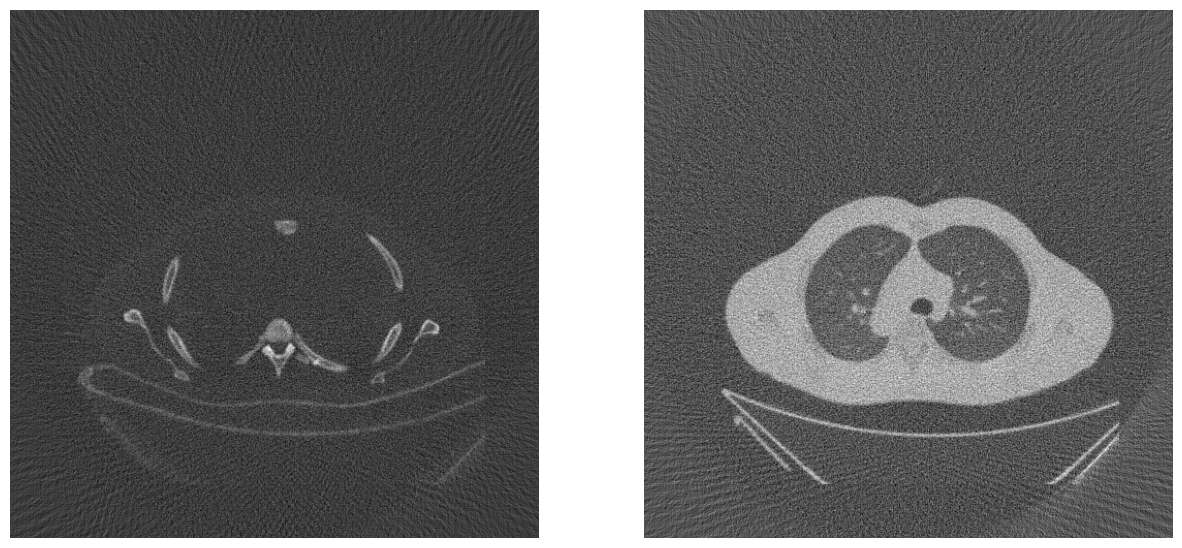

In [3]:
from Utils.FBP_Pinv import FBP_Pinv
x_scout, PSNR_fbp_pinv, SSIM_fbp_pinv  = FBP_Pinv(Mat, Spect, Measures)

fig, ax = plt.subplots(1,Mat.n_mat, figsize=(15,15))
for k in range(2):
    ax[k].imshow(x_scout.detach().cpu()[0,k], cmap='gray')
    ax[k].axis('off')
plt.show()

## PWLS + Pinv

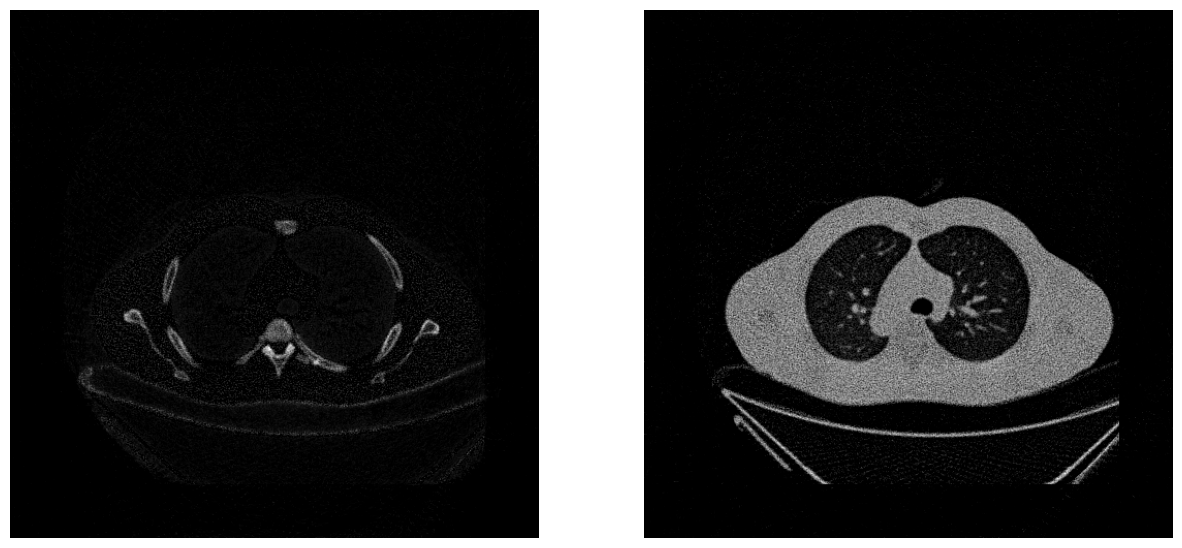

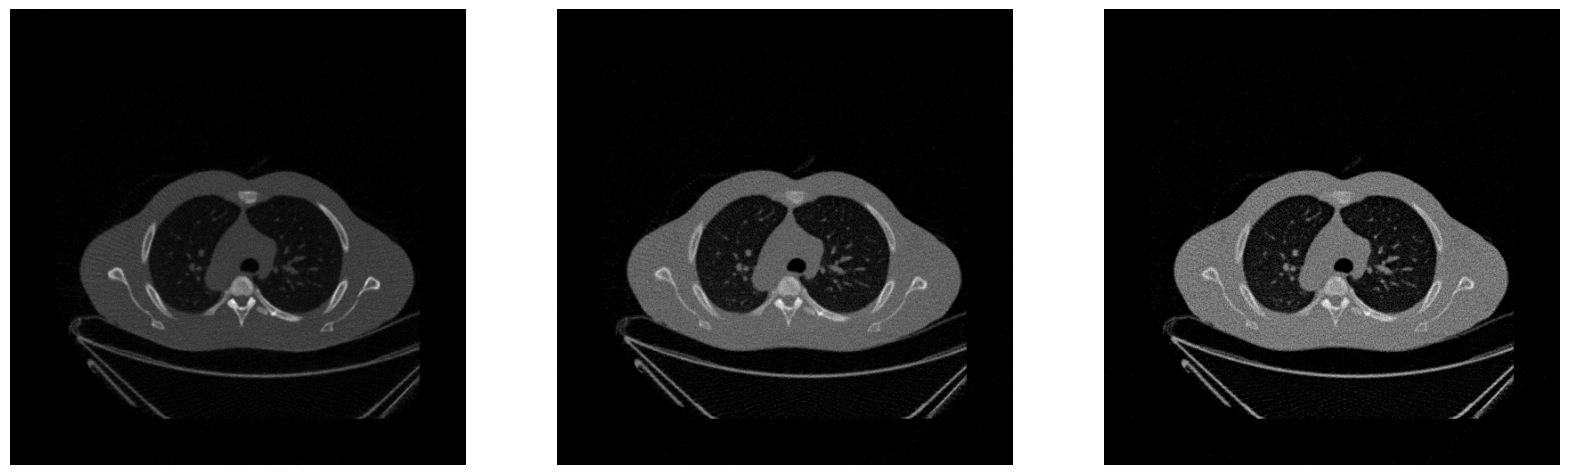

In [4]:
from Utils.PWLS import PWLS
# PWLS
x_mat_pwls, x_spec_pwls, PSNR_pwls, SSIM_pwls = PWLS(Mat, Spect, Measures,
                                                     x_scout, 
                                                     n_iter= 200, 
                                                     delta = 1e-3, 
                                                     beta_prior = torch.tensor([1e10,3e10,5e10], device=device), 
                                                     device = device)

x_pwls_np = x_mat_pwls.detach().cpu().numpy()

fig, ax = plt.subplots(1,Mat.n_mat, figsize=(15,15))
for k in range(Mat.n_mat):
    ax[k].imshow(x_pwls_np[0,k], cmap='gray')
    ax[k].axis('off')
plt.show()
fig, ax = plt.subplots(1,Spect.n_bin, figsize=(20,15))
for k in range(Spect.n_bin):
    ax[k].imshow(x_spec_pwls[0,k].detach().cpu().numpy(), cmap='gray')
    ax[k].axis('off')
plt.show()


## One-step DPS

With gradient approximated by gradient of log-likehood (gradapprox) and with autogradient.

time : 93.5394196510315


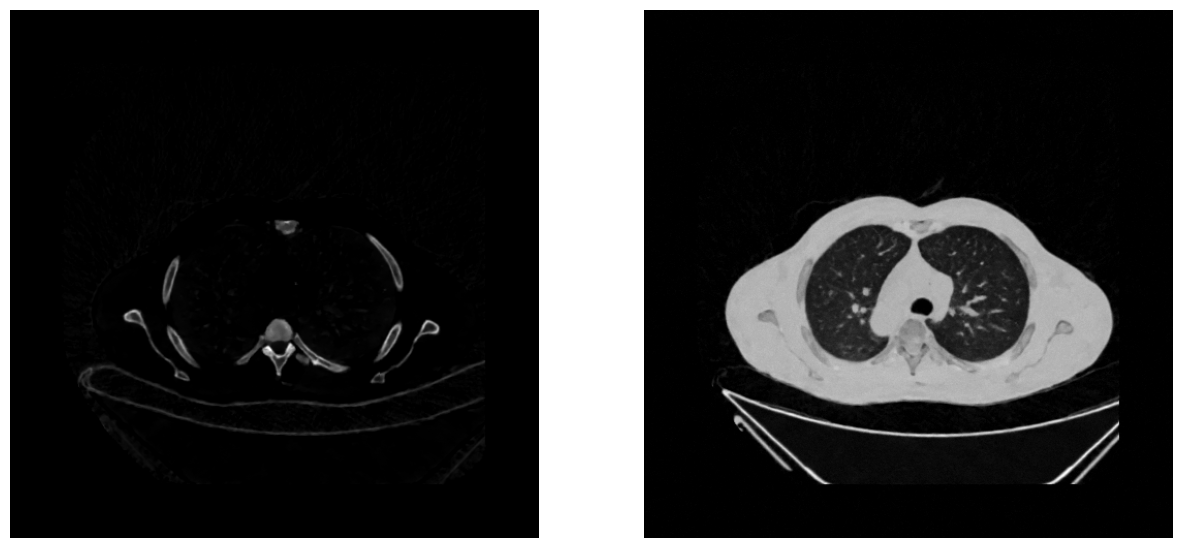

In [5]:
from Utils.ODPS import ODPS_method

grad_approx = True
start = time.time()
x_odps_gradapprox, PSNR_odps_gradapprox, SSIM_odps_gradapprox = ODPS_method(Mat, Spect, Measures, ODPS,
                                                                    x_scout =x_scout,
                                                                    t_prime = 750,
                                                                    step = torch.tensor([0.4,0.4], device=device)[None,:,None,None],
                                                                    grad_approx = grad_approx,
                                                                    device = device)
end = time.time()
print(f'time : {end-start}')
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(x_odps_gradapprox[0,0].detach().cpu().numpy(), cmap='gray')
ax[0].axis('off')
ax[1].imshow(x_odps_gradapprox[0,1].detach().cpu().numpy(), cmap='gray')
ax[1].axis('off')
plt.show()

time : 84.29191184043884


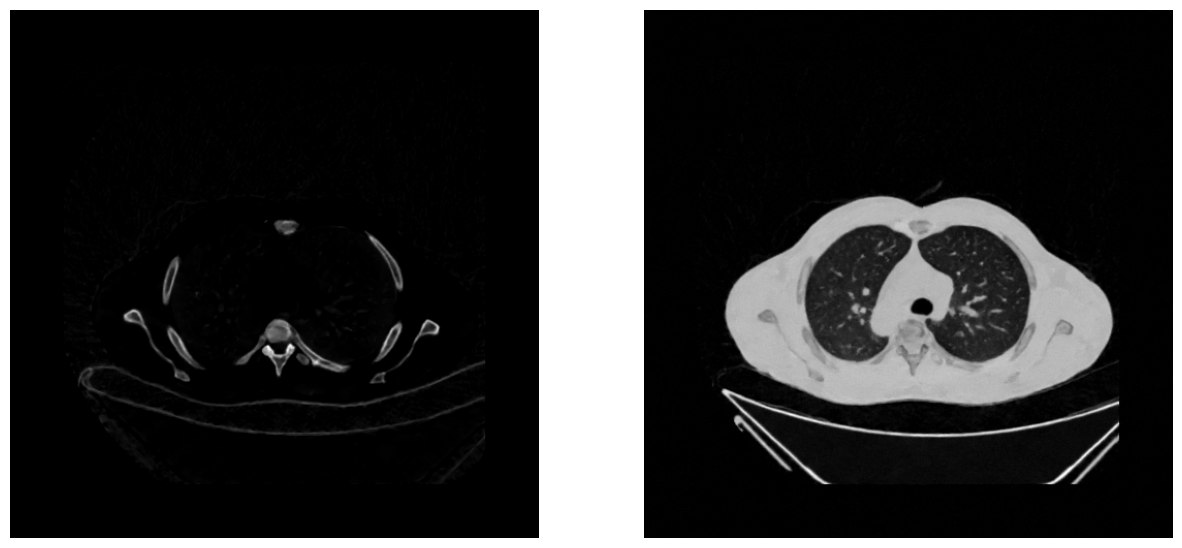

In [6]:
grad_approx = False
start = time.time()
x_odps_autograd, PSNR_odps_autograd, SSIM_odps_autograd = ODPS_method(Mat, Spect, Measures, ODPS,
                                                                      x_scout =x_scout,
                                                                      t_prime = 750,
                                                                      step = torch.tensor([0.4,0.4], device=device)[None,:,None,None],
                                                                      grad_approx = grad_approx,
                                                                      device = device)
end = time.time()
print(f'time : {end-start}')
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(x_odps_autograd[0,0].detach().cpu().numpy(), cmap='gray')
ax[0].axis('off')
ax[1].imshow(x_odps_autograd[0,1].detach().cpu().numpy(), cmap='gray')
ax[1].axis('off')
plt.show()

## Two-step DPS

time : 86.92313885688782


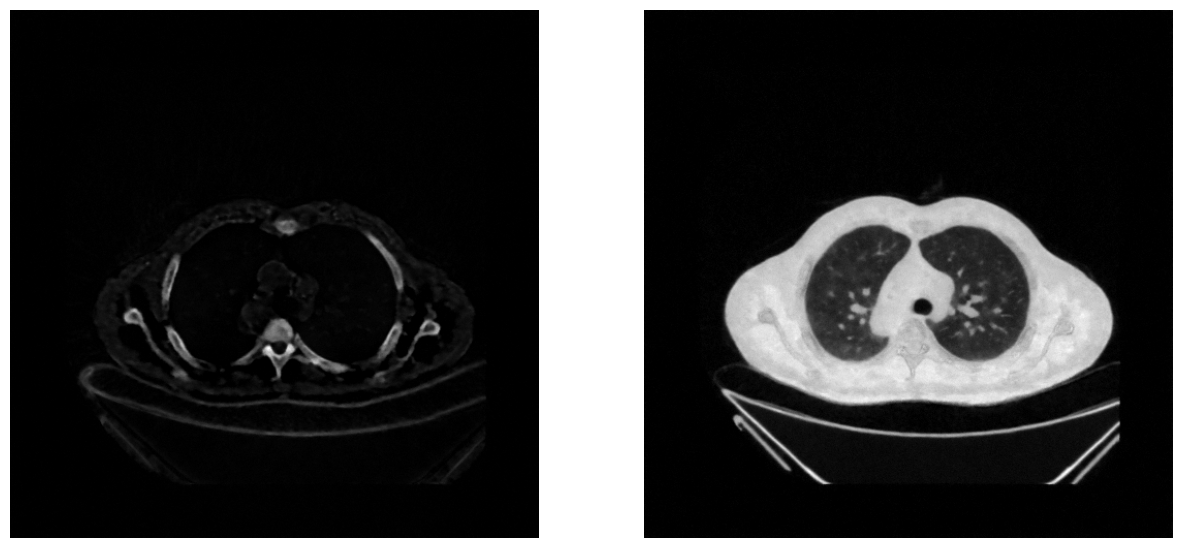

In [7]:
from Utils.TDPS import TDPS_method

start = time.time()
x_tdps, x_tdps_pseudo_spectral, PSNR_tdps, SSIM_tdps = TDPS_method(Mat, Spect, Measures, TDPS,
                                           x_scout =x_scout,
                                           t_prime = 750,
                                           step = torch.tensor([0.3,0.3,0.3], device=device)[None,:,None,None],
                                           device = device)
end = time.time()
print(f'time : {end-start}')
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(x_tdps[0,0], cmap='gray')
ax[0].axis('off')
ax[1].imshow(x_tdps[0,1], cmap='gray')
ax[1].axis('off')
plt.show()

## One-step LBFGS with penalization (huber + inner product)

In [8]:
from Utils.OneStepLBFGS import OneStepLBFGS
beta = 1e3 # huber prior weight
gamma = 1e2 # inner product weight
start = time.time()
x_lbfgs, PSNR_OnestepLBFGS, SSIM_OnestepLBFGS = OneStepLBFGS(Mat, Spect, Measures,
                                                             x_scout,
                                                             beta,
                                                             gamma,
                                                             device)
end = time.time()
print(f'time : {end-start}')

time : 19.616658210754395


## Two-step Projection Domain :
### Step 1 : Material sinograms from measures. (LBFGS with huber penalization)
### Step 2 : Material images from material sinograms. (DPS method)

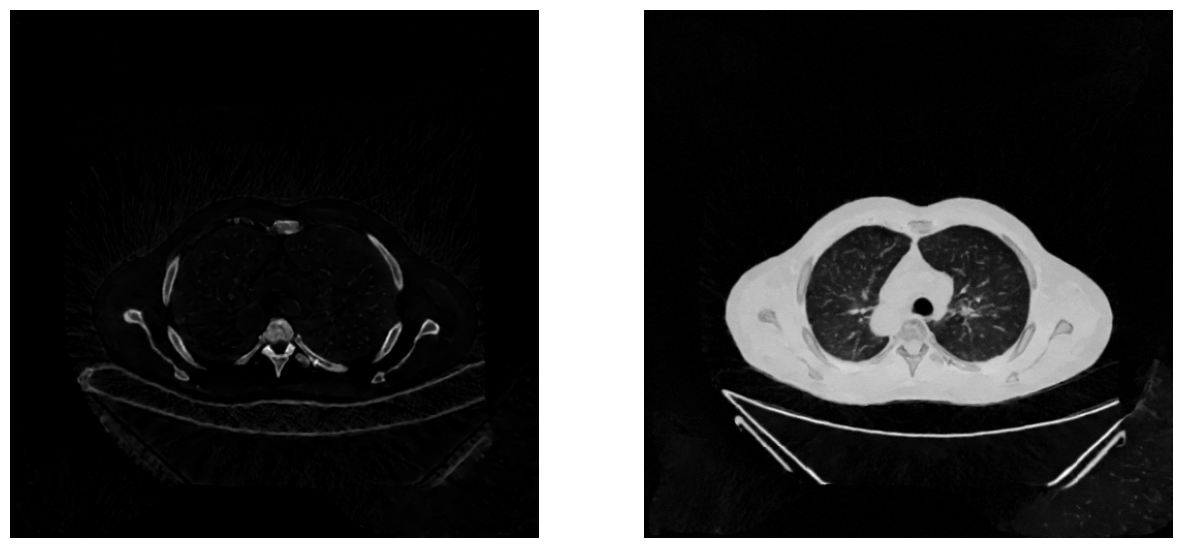

In [9]:
from Utils.ProjectionDomainDPS import ProjectionDomainDPS_method
x_ProjDomainDPS, PSNR_ProjDomainDPS, SSIM_ProjDomainDPS = ProjectionDomainDPS_method(Mat, Spect, Measures, ODPS,
                                                             x_scout,
                                                             beta = 0.1,
                                                             t_prime = 750,
                                                             step = torch.tensor([0.2,0.2], device=device)[None,:,None,None],
                                                             device = device)


fig, ax = plt.subplots(1,Mat.n_mat, figsize=(15,15))
for k in range(Mat.n_mat):
    ax[k].imshow(x_ProjDomainDPS[0,k].detach().cpu(), cmap='gray')
    ax[k].axis('off')
plt.show()

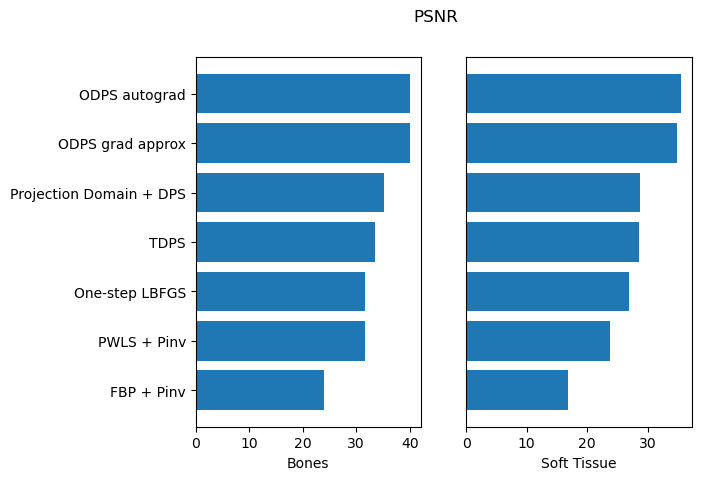

In [20]:
methods = ('FBP + Pinv', 'PWLS + Pinv', 'ODPS grad approx', 'ODPS autograd', 'TDPS', 'One-step LBFGS', 'Projection Domain + DPS') 
Material_list = ('Bones', 'Soft Tissue')
y_pos = np.arange(len(methods))
fig, ax = plt.subplots(1,2)
psnr_array = np.asarray([PSNR_fbp_pinv[0], PSNR_pwls[-1,0], PSNR_odps_gradapprox[-1,0], PSNR_odps_autograd[-1,0], PSNR_tdps[-1,0], PSNR_OnestepLBFGS[0], PSNR_ProjDomainDPS[-1,0]])
permutation = np.argsort(-psnr_array)
psnr_array_sorted = -np.sort(-psnr_array)
for n in range(Mat.n_mat):
    psnr_array = np.asarray([PSNR_fbp_pinv[n], PSNR_pwls[-1,n], PSNR_odps_gradapprox[-1,n], PSNR_odps_autograd[-1,n], PSNR_tdps[-1,n], PSNR_OnestepLBFGS[n], PSNR_ProjDomainDPS[-1,n]])
    hbars = ax[n].barh(y_pos, psnr_array[permutation], align='center')
    ax[n].invert_yaxis()  # labels read top-to-bottom
    ax[n].set_xlabel(f'{Material_list[n]}')
ax[0].set_yticks(y_pos, labels=np.asarray(methods)[permutation])
ax[1].set_yticks([],[])
plt.suptitle('PSNR')
plt.show()

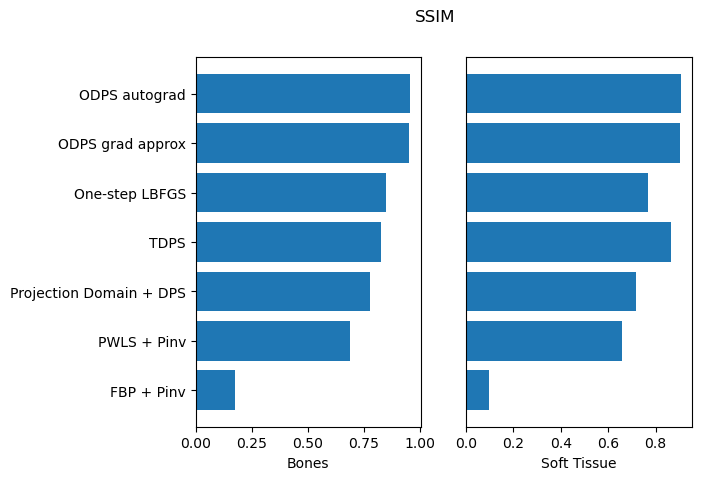

In [19]:
methods = ('FBP + Pinv', 'PWLS + Pinv', 'ODPS grad approx', 'ODPS autograd', 'TDPS', 'One-step LBFGS', 'Projection Domain + DPS') 
Material_list = ('Bones', 'Soft Tissue')
y_pos = np.arange(len(methods))
fig, ax = plt.subplots(1,2)
ssim_array = np.asarray([SSIM_fbp_pinv[0], SSIM_pwls[-1,0], SSIM_odps_gradapprox[-1,0], SSIM_odps_autograd[-1,0], SSIM_tdps[-1,0], SSIM_OnestepLBFGS[0], SSIM_ProjDomainDPS[-1,0]])
permutation = np.argsort(-ssim_array)
ssim_array_sorted = -np.sort(-ssim_array)
for n in range(Mat.n_mat):
    ssim_array = np.asarray([SSIM_fbp_pinv[n], SSIM_pwls[-1,n], SSIM_odps_gradapprox[-1,n], SSIM_odps_autograd[-1,n], SSIM_tdps[-1,n], SSIM_OnestepLBFGS[n], SSIM_ProjDomainDPS[-1,n]])
    hbars = ax[n].barh(y_pos, ssim_array[permutation], align='center')
    ax[n].invert_yaxis()  # labels read top-to-bottom
    ax[n].set_xlabel(f'{Material_list[n]}')
ax[0].set_yticks(y_pos, labels=np.asarray(methods)[permutation])
ax[1].set_yticks([],[])
plt.suptitle('SSIM')
plt.show()

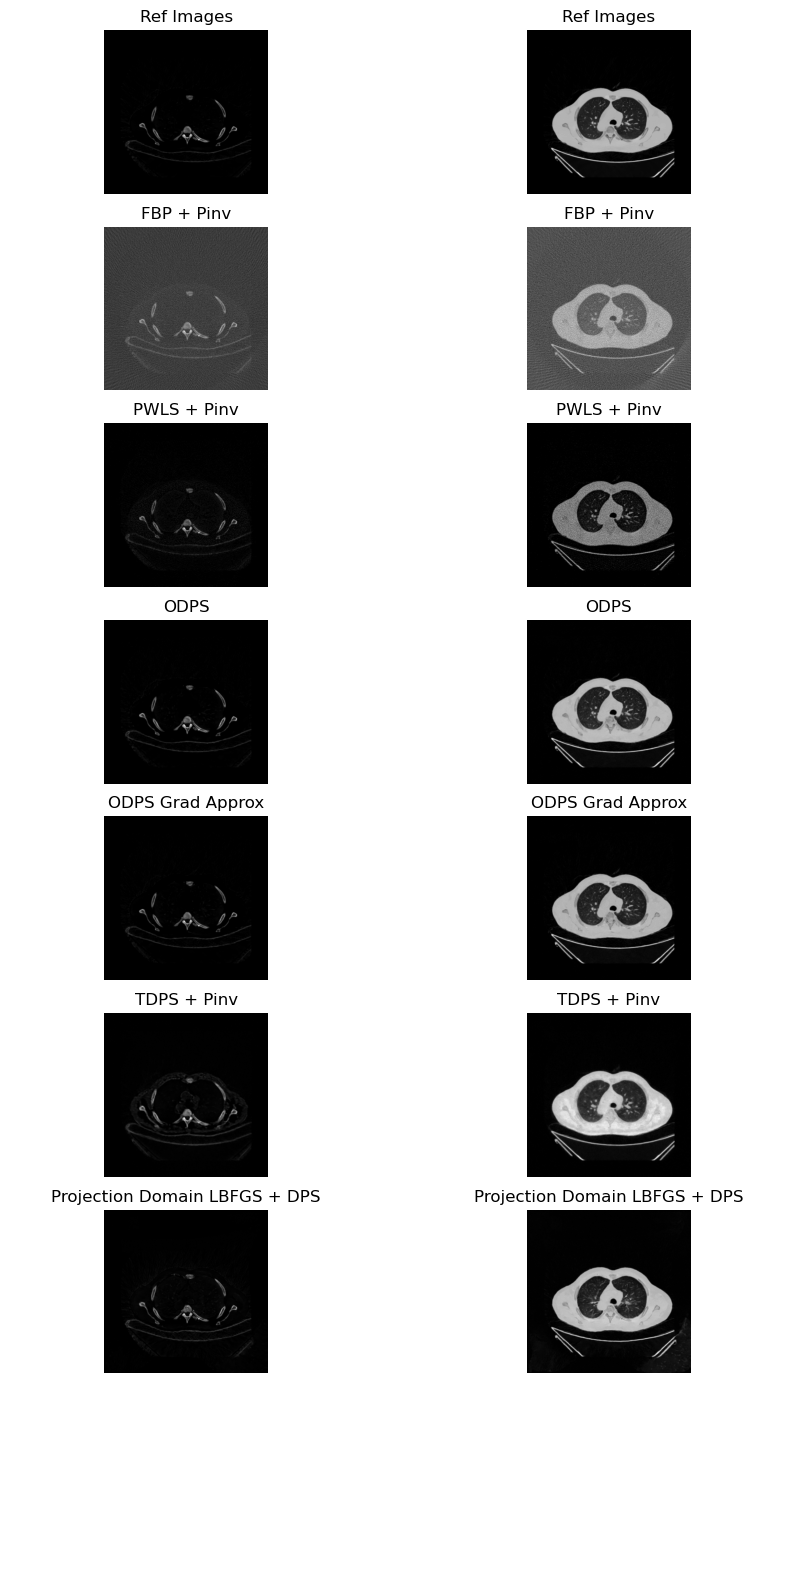

In [16]:
fig, ax = plt.subplots(8,2, figsize=(10,20))
for k in range(2):
    ax[0,k].imshow(Mat.x_mass_densities[0,k].detach().cpu().numpy(), cmap='gray')
    ax[0,k].set_title('Ref Images')
    ax[1,k].imshow(x_scout.detach().cpu()[0,k], cmap='gray')
    ax[1,k].set_title(f"FBP + Pinv")
    ax[2,k].imshow(x_pwls_np[0,k], cmap='gray')
    ax[2,k].set_title(f"PWLS + Pinv")
    ax[3,k].imshow(x_odps_autograd[0,k].detach().cpu(), cmap='gray')
    ax[3,k].set_title(f"ODPS")
    ax[4,k].imshow(x_odps_gradapprox[0,k].detach().cpu(), cmap='gray')
    ax[4,k].set_title(f"ODPS Grad Approx")
    ax[5,k].imshow(x_tdps[0,k], cmap='gray')
    ax[5,k].set_title(f"TDPS + Pinv")
    ax[6,k].imshow(x_lbfgs[0,k], cmap='gray')
    ax[6,k].set_title(f"One-step LBFGS")
    ax[6,k].imshow(x_ProjDomainDPS[0,k].detach().cpu(), cmap='gray')
    ax[6,k].set_title(f"Projection Domain LBFGS + DPS")
    ax[0,k].axis('off')
    ax[1,k].axis('off')
    ax[2,k].axis('off')
    ax[3,k].axis('off')
    ax[4,k].axis('off')
    ax[5,k].axis('off')
    ax[6,k].axis('off')
    ax[7,k].axis('off')